# Calculating and visualizing 3D-mPDF patterns

3D-mPDF calculations (see https://doi.org/10.1107/S2052252518006590 and https://doi.org/10.1103/PhysRevB.100.144404) can be performed in diffpy.mpdf using the MPDF3Dcalculator class. Similar to the standard MPDFcalculator class, a MagStructure object is provided to the calculator, from which the positions and magnetic moments are extracted. Here, we use antiferromagnetic MnTe as an example. It is known to have an anisotropic correlation length in the correlated paramagnet regime above the ordering temperature, with a significantly longer correlation length along the c-axis than within the ab-plane (see https://doi.org/10.1016/j.matt.2022.03.011 for more details). This anisotropy makes it a useful example case for 3D-mPDF.

In [2]:
import diffpy.mpdf as mpdf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

## Make the MagStructure

We will create a MagStructure object from the MCIF file for MnTe.

In [3]:
mag = mpdf.create_from_mcif('0.800_MnTe.mcif',ffparamkey='Mn2',rmaxAtoms=30)
mag.makeAll()

MagStructure creation from mcif file successful.


Create an anisotropic correlation length using the dampingMat attribute. This is a 3x3 symmetric matrix for which the eigenvalues are equal to the inverse squared correlation length along the direction given by the corresponding eigenvector. See the J. Appl. Cryst. paper for more details. 

In [4]:
xi_ab = 4
xi_c = 8
mag.dampingMat = np.array([[1/xi_ab**2, 0, 0],
                           [0, 1/xi_ab**2, 0],
                           [0, 0, 1/xi_c**2]])

## Make the MPDF3Dcalculator

Now we create an instance of the MPDF3Dcalculator class and feed it our MagStructure object.

In [5]:
calc = mpdf.MPDF3Dcalculator(magstruc=mag)
calc.gaussPeakWidth = 0.7 # sets the broadening of the peaks due to the spatial extent of the wavefunction

Here we are using a three-dimensional Gaussian to represent the spatial extent of wavefunction giving rise to the magnetic moment. The gaussPeakWidth attribute controls the broadening of the peaks and has a default value of 0.5. 

## Perform the calculation

The MPDF3Dcalculator.calc() method calls the primary computation method of the class. An optional argument of 'dr' can be used which will adjust the spatial resolution of the magnetic structure representation and the final mpdf. A larger dr value will decrease computaional costs but lower the resolution of the final mpdf calculated. As a note, because this computation is done in 3D, computation time and memory scale by dr<sup>3</sup>.

In [6]:
calc.calc(dr=0.4)

/home/byu.local/benjam23/shares/quant/software/mpdfdev/mcif-branch/diffpy.mpdf/diffpy/mpdf/magstructure.py:947: RuntimeWarning: invalid value encountered in true_divide
  distanceVecsN = distanceVecs/np.apply_along_axis(np.linalg.norm,1,distanceVecs)[:,np.newaxis]


## Extract and visualize the results

The MPDF3Dcalculator.rgrid() method returns the real space grid used to compute the 3D-mPDF, while the MPDF3Dcalculator.mpdf attribute stores the calculated 3D-mPDF. Note that this is not defined until the computation is run.

In [7]:
x,y,z = calc.rgrid()
mpdf3D = calc.mpdf

Now we visualize the results using the diffpy.mpdf.visualize3D module. This module generates a user-defined 2D slice of a 3D data set. We start by making an instance of the Visualizer class, which takes as input the 3D data set and the Cartesian x, y, and z arrays over which the data set is defined.

In [8]:
import diffpy.mpdf.visualize3D as v3d
vis = v3d.Visualizer(mpdf3D, x, y, z)

Now we define the 2D slice we want to extract. Two methods can be used to accomplish this:
 - Method 1: Define a center point and a normal vector. The 2D slice will consist of the plane perpendicular to the normal vector centered on the given center point.
 - Method 2: Define three non-collinear points. The 2D slice will consist of the plane containing these three points, centered on the centroid of the three points.
 
We will use Method 1 first.

<IPython.core.display.Javascript object>


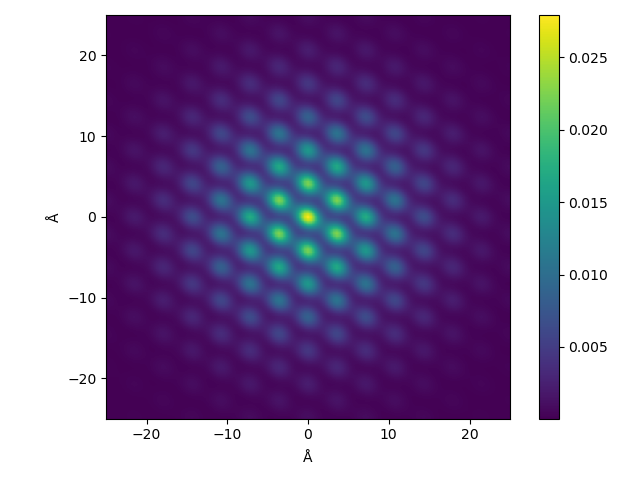

In [9]:
len_horizontal = 50 # horizontal extent of the slice
len_vertical = 50 # vertical extent of the slice
stepsize = 0.2 # step size for the interpolation used to make the slice

# Let's first look in the ab plane, i.e. perpendicular to [0,0,1].
center = np.array([0,0,0])
normal = np.array([0,0,1])
vis.make_slice(len_horizontal, len_vertical, stepsize,
               use_normal = True, cen_pt=center, normal=normal)

# Now we just call the visualize() method
vis.visualize()

Note that all the peaks are positive due to ferromagnetic alignment within the ab plane. Now let's look in the bc plane, where we expect antiferromagnetic alignment along the c direction.

<IPython.core.display.Javascript object>


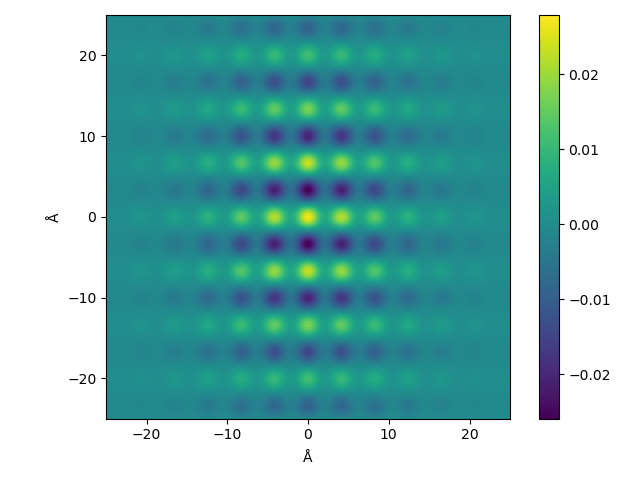

In [10]:
center = np.array([0,0,0])
normal = np.array([1,0,0]) # looking in the bc plane
vis.make_slice(len_horizontal, len_vertical, stepsize,
               use_normal = True, cen_pt=center, normal=normal)

# Now we just call the visualize() method
vis.visualize()

We see alternating positive and negative peaks along the vertical direction, as expected. Additionally, we see that the correlations are longer lived along the c direction (vertical) than along the b direction (horizontal), due to the anisotropic correlation length we implemented earlier.

As a side note, you can also return the data slice for further manipulation or visualization by setting the returnSlice attribute to True:

In [11]:
data_slice, xx, yy = vis.make_slice(len_horizontal, len_vertical, stepsize,
                                    use_normal = True, cen_pt=center, normal=normal,
                                    returnSlice=True)
print(data_slice.shape, xx.shape, yy.shape)

(251, 251) (251,) (251,)


For completeness, let's now use Method 2 to generate a slice for visualization. We will choose three corners of the unit cell as our three points to define the plane. Note that in this case, this choice of points does not yield a particularly useful plane to look at, but it still demonstrates the functionality.

Center Point: [1.19728012 0.69125    2.23666667]


<IPython.core.display.Javascript object>


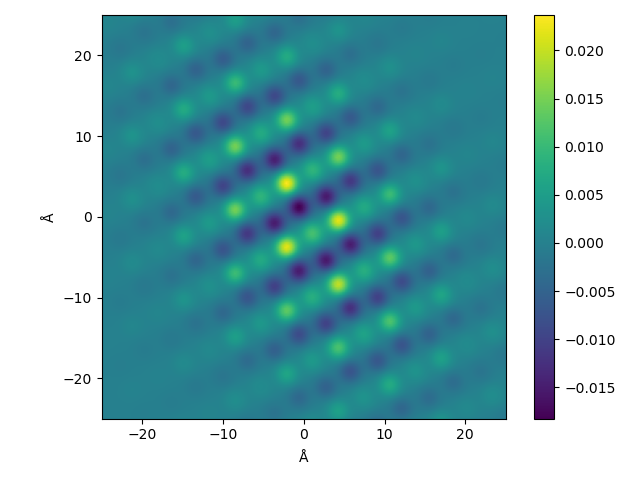

In [12]:
lat = mag.struc.lattice
avec, bvec, cvec = lat.stdbase
vis.make_slice(len_horizontal, len_vertical, stepsize,
               use_normal=False,
               p1=avec, p2=bvec, p3=cvec)

# Now we just call the visualize() method
vis.visualize()

In [13]:
plt.close('all')